

# Movie Recommender with Collaborative Filtering
This approach is mostly preferred since the movie don't change much. We can rerun this model once a week unlike User based where we have to frequently run the model.

In this kernel, We look at the implementation of Item based filtering

In [ ]:
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

Ratings dataset has

* userId - unique for each user
* movieId - using this feature ,we take the title of the movie from movies dataset
* rating - Ratings given by each user to all the movies using this I'm are going to predict the top 10 similar movies

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1.147880e+09
1,1,306,3.5,1.147869e+09
2,1,307,5.0,1.147869e+09
3,1,665,5.0,1.147879e+09
4,1,899,3.5,1.147869e+09


Movie dataset has
* movieId - once the recommendation is done, we get list of all similar movieId and get the title for each movie from this dataset.
* genres -  which is not required for this filtering approach

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Since the dataset is large, we should limit it if we're reading directly



In [ ]:
ratings = ratings[ratings["userId"].isin(np.arange(1,20001))]
ratings.tail()

,userId,movieId,rating,timestamp
3030794,20000,553,3.0,835252995.0
3030795,20000,588,3.0,835252807.0
3030796,20000,590,3.0,835252784.0
3030797,20000,592,2.0,835252784.0
3030798,20000,593,4.0,835252869.0


In [ ]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset

userId,1,2,3,4,5,6,7,8,9,10,...,19991,19992,19993,19994,19995,19996,19997,19998,19999,20000
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.5,4.0,3.0,4.0,NaN,NaN,4.0,NaN,3.5,...,NaN,4.0,NaN,NaN,NaN,NaN,4.5,5.0,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need to fill missing reviews as 0 to not affect the calculations

In [ ]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,19991,19992,19993,19994,19995,19996,19997,19998,19999,20000
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,4.0,0.0,0.0,4.0,0.0,3.5,...,0.0,4.0,0.0,0.0,0.0,0.0,4.5,5.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In a real world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. So we will reduce the noise by adding some filters and qualify the movies for the final dataset.
* To qualify a movie, minimum 40 users should have voted a movie.
* To qualify a user, minimum 50 movies should have voted by the user.


In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

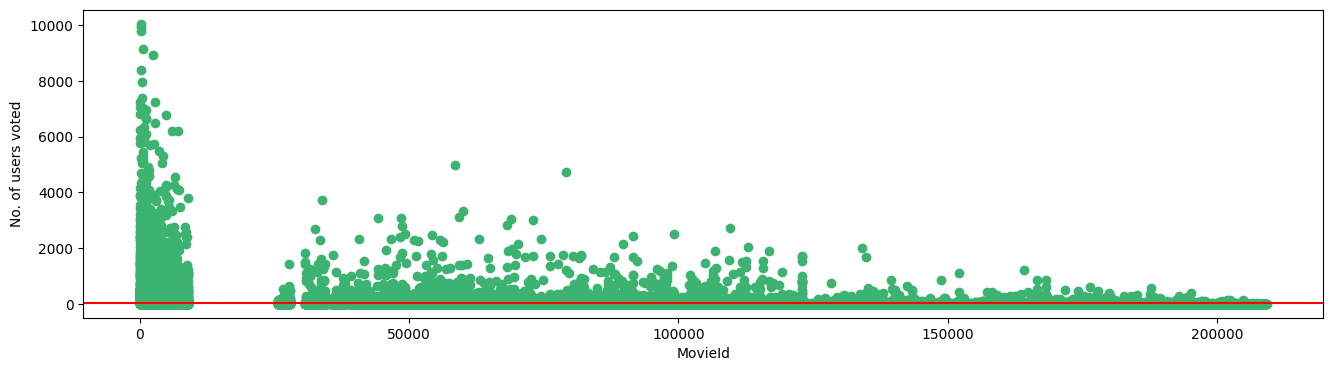

In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [ ]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 40].index,:]

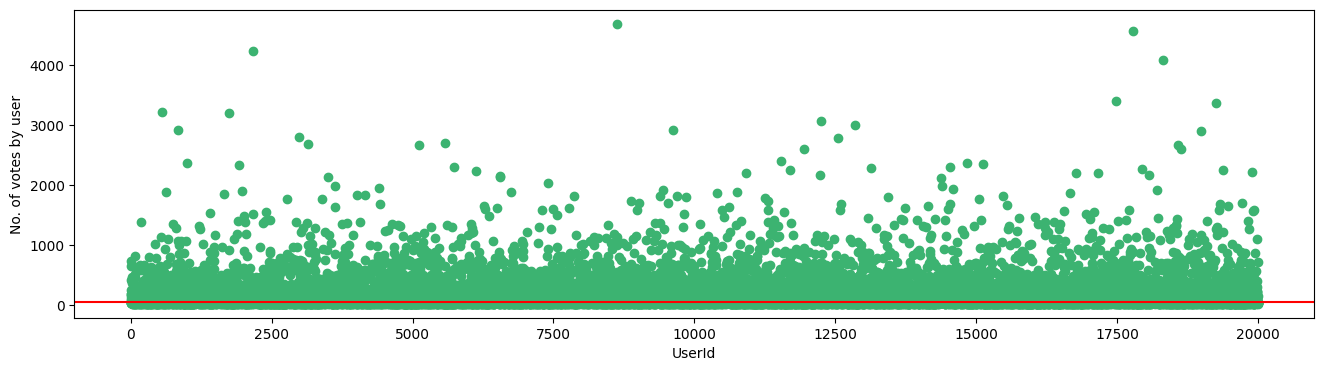

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [ ]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]

I took only small dataset but for
original large dataset of movie lens, this will sure hang our system when this has
feed to model. To reduce the sparsity we use csr_matric scipy lib.

In [ ]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


* As you can see there is no sparse value in the csr_sample and values are assigned as rows and column index. for the 0th row and 2nd column , value is 3 . Look at the original dataset where the values at the right place. This is how it works using todense method you can take it back to original dataset.
* Most of the sklearn works with sparse matrix. surely this will improve our performance

In [ ]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

We use cosine distance metric which is very fast and preferable than pearson coefficient.

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [ ]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]
    if len(movie_list):
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]

        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]

        recommend_frame = []

        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df

    else:

        return "No movies found. Please check your input"

In [ ]:
get_movie_recommendation('High School Musical')

,Title,Distance
1,Cheaper by the Dozen 2 (2005),0.703351
2,Hairspray (2007),0.689399
3,17 Again (2009),0.686637
4,Raise Your Voice (2004),0.651129
5,"Cinderella Story, A (2004)",0.647888
6,The Lizzie McGuire Movie (2003),0.643167
7,Hannah Montana: The Movie (2009),0.640678
8,Camp Rock (2008),0.493120
9,High School Musical 3: Senior Year (2008),0.347003
10,High School Musical 2 (2007),0.293071


In [ ]:
get_movie_recommendation('Memento')

,Title,Distance
1,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",0.417294
2,Kill Bill: Vol. 1 (2003),0.416807
3,Donnie Darko (2001),0.413313
4,The Lord of the Rings: Two Towers The (2002),0.411138
5,Pulp Fiction (1994),0.402662
6,American Beauty (1999),0.389373
7,The Lord of the Rings: Fellowship of the Ring ...,0.383980
8,Eternal Sunshine of the Spotless Mind (2004),0.375091
9,The Matrix (1999),0.366119
10,Fight Club (1999),0.310089


In [ ]:
get_movie_recommendation('Interstellar')

,Title,Distance
1,The Wolf of Wall Street (2013),0.394433
2,Mad Max: Fury Road (2015),0.388367
3,Ex Machina (2015),0.385062
4,The Imitation Game (2014),0.384192
5,Guardians of the Galaxy (2014),0.379601
6,The Dark Knight Rises (2012),0.379122
7,Edge of Tomorrow (2014),0.368154
8,Django Unchained (2012),0.360674
9,Inception (2010),0.314823
10,The Martian (2015),0.313422


Our model works perfectly predicting the recommendation based on user behaviour and past search. So we conclude our
collaborative filtering here.
